In [138]:
import numpy as np 
import seaborn as sns 
import pandas as pd 
import matplotlib.pyplot as plt 
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression, Ridge,Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from sklearn.model_selection import RandomizedSearchCV
from catboost import CatBoostRegressor
from xgboost import XGBRegressor


In [139]:
df=pd.read_csv("data/stud.csv")

In [140]:
df.head()

,gender,race/ethnicity,parental level of education,lunch,test preparation course,math score,reading score,writing score
0,female,group D,some college,standard,completed,59,70,78
1,male,group D,associate's degree,standard,none,96,93,87
2,female,group D,some college,free/reduced,none,57,76,77
3,male,group B,some college,free/reduced,none,70,70,63
4,female,group D,associate's degree,standard,none,83,85,86


In [141]:
df_new=df.copy()
df_new['total_score']=df_new['math score']+df_new['writing score']+df_new['reading score']
df_new['average']=round(df_new['total_score']/3,2)
df_new

,gender,race/ethnicity,parental level of education,lunch,test preparation course,math score,reading score,writing score,total_score,average
0,female,group D,some college,standard,completed,59,70,78,207,69.00
1,male,group D,associate's degree,standard,none,96,93,87,276,92.00
2,female,group D,some college,free/reduced,none,57,76,77,210,70.00
3,male,group B,some college,free/reduced,none,70,70,63,203,67.67
4,female,group D,associate's degree,standard,none,83,85,86,254,84.67
...,...,...,...,...,...,...,...,...,...,...
995,male,group C,some college,standard,none,77,77,71,225,75.00
996,male,group C,some college,standard,none,80,66,66,212,70.67
997,female,group A,high school,standard,completed,67,86,86,239,79.67
998,male,group E,high school,standard,none,80,72,62,214,71.33


In [142]:
#x=df_new.select_dtypes(include='object')
x=df_new.drop(columns=['total_score','average'],axis=1)
x

,gender,race/ethnicity,parental level of education,lunch,test preparation course,math score,reading score,writing score
0,female,group D,some college,standard,completed,59,70,78
1,male,group D,associate's degree,standard,none,96,93,87
2,female,group D,some college,free/reduced,none,57,76,77
3,male,group B,some college,free/reduced,none,70,70,63
4,female,group D,associate's degree,standard,none,83,85,86
...,...,...,...,...,...,...,...,...
995,male,group C,some college,standard,none,77,77,71
996,male,group C,some college,standard,none,80,66,66
997,female,group A,high school,standard,completed,67,86,86
998,male,group E,high school,standard,none,80,72,62


In [143]:
y=df_new['total_score']
y

0      207
1      276
2      210
3      203
4      254
      ... 
995    225
996    212
997    239
998    214
999    150
Name: total_score, Length: 1000, dtype: int64

### Create column Transformer with 3 types of transformers

In [144]:
cat_features=x.select_dtypes(include='object').columns  #if x had any numerical feature we had to break like this
num_features=x.select_dtypes(exclude='object').columns

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer

scaler=StandardScaler()
oh=OneHotEncoder()

preprocessor=ColumnTransformer(
    [
        ("One hot Encoder", oh,cat_features),
        ("Standard Scaler",scaler,num_features)
    ]
)

#this is required when we have X with categorical and numerical features both but now we have only cat features in X



In [145]:
x_encoded=preprocessor.fit_transform(x)
# oh=OneHotEncoder()
# x_encoded=oh.fit_transform(x)

In [146]:
x_encoded.shape

(1000, 20)

In [147]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test=train_test_split(x_encoded,y,test_size=0.2, random_state=42 )
X_train.shape, X_test.shape

((800, 20), (200, 20))

In [148]:
def evaluate_model(true,predicted):
    mae=mean_absolute_error(true, predicted)
    mse=mean_squared_error(true,predicted)
    rmse=np.sqrt(mean_squared_error(true,predicted))
    r2_square=r2_score(true,predicted)
    return mae,mse,rmse,r2_square



In [149]:
models={"LinearRegression":LinearRegression(),
        "Lasso Regression":Lasso(),
        "Ridge Regression":Ridge(),
        "Random Forest":RandomForestRegressor(),
        "Decision Tree":DecisionTreeRegressor(),
        "K-Neighbors":KNeighborsRegressor(),
        "XGBoost":XGBRegressor(),
        "Ada Boost":AdaBoostRegressor(),
        "CatBoosting":CatBoostRegressor(verbose=False)}

models_list=[]
r2_list=[]

for i in range(len(list(models))):
    model=list(models.values())[i]
    model.fit(X_train,Y_train)

    #prediction
    y_train_pred=model.predict(X_train)
    y_test_pred=model.predict(X_test)

    #evaluate model
    train_mae, train_mse, train_rmse, train_r2_square= evaluate_model(Y_train,y_train_pred)
    test_mae, test_mse, test_rmse, test_r2_square= evaluate_model(Y_test, y_test_pred)

    models_list.append(list(models.keys())[i])
    print(list(models.keys())[i],"\n")

    print("MODEL TRAINING PERFORMANCE")
    print("- Root Mean Squared Error: {:.4f}".format(train_rmse))
    print("- Mean Absolute Error: {:.4f}".format(train_mae))
    print("- R2 Score: {:.4f}".format(train_r2_square))

    print("\nMODEL TESTING PERFORMANCE")
    print("- Root Mean Squared Error: {:.4f}".format(test_rmse))
    print("- Mean Absolute Error: {:.4f}".format(test_mae))
    print("- R2 Score: {:.4f}".format(test_r2_square))
    r2_list.append(test_r2_square)
    print("*"*20,"\n\n")


LinearRegression 

MODEL TRAINING PERFORMANCE
- Root Mean Squared Error: 0.0000
- Mean Absolute Error: 0.0000
- R2 Score: 1.0000

MODEL TESTING PERFORMANCE
- Root Mean Squared Error: 0.0000
- Mean Absolute Error: 0.0000
- R2 Score: 1.0000
******************** 


Lasso Regression 

MODEL TRAINING PERFORMANCE
- Root Mean Squared Error: 1.0445
- Mean Absolute Error: 0.8452
- R2 Score: 0.9994

MODEL TESTING PERFORMANCE
- Root Mean Squared Error: 0.9768
- Mean Absolute Error: 0.7829
- R2 Score: 0.9994
******************** 


Ridge Regression 

MODEL TRAINING PERFORMANCE
- Root Mean Squared Error: 0.0237
- Mean Absolute Error: 0.0192
- R2 Score: 1.0000

MODEL TESTING PERFORMANCE
- Root Mean Squared Error: 0.0224
- Mean Absolute Error: 0.0179
- R2 Score: 1.0000
******************** 


Random Forest 

MODEL TRAINING PERFORMANCE
- Root Mean Squared Error: 0.9247
- Mean Absolute Error: 0.6023
- R2 Score: 0.9995

MODEL TESTING PERFORMANCE
- Root Mean Squared Error: 1.9692
- Mean Absolute Error: 1

In [150]:
result=pd.DataFrame(list(zip(models_list,r2_list)), columns=['Model', 'R2 Score']).sort_values(by=['R2 Score'],ascending=False)
result

,Model,R2 Score
0,LinearRegression,1.000000
2,Ridge Regression,1.000000
1,Lasso Regression,0.999377
8,CatBoosting,0.999245
3,Random Forest,0.997469
6,XGBoost,0.996819
4,Decision Tree,0.982446
7,Ada Boost,0.977887
5,K-Neighbors,0.951686


Linear Regression Model

In [151]:
lin_reg=LinearRegression(fit_intercept=True)
lin_model=lin_reg.fit(X_train,Y_train)
lin_y_pred=lin_model.predict(X_test)
score = r2_score(Y_test, lin_y_pred)*100
print(" Accuracy of the model is %.2f" %score)

 Accuracy of the model is 100.00


Text(0, 0.5, 'Predicted')

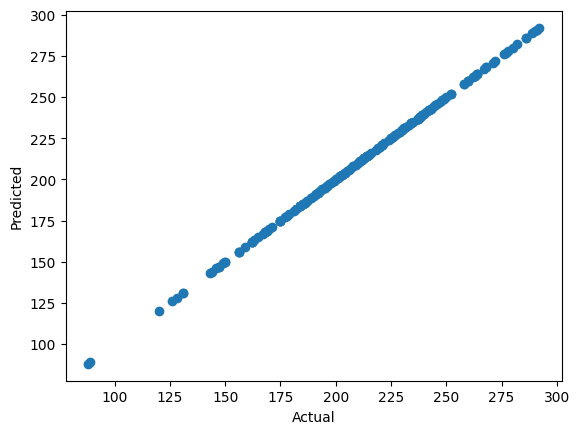

In [152]:
plt.scatter(Y_test,lin_y_pred)
plt.xlabel('Actual')
plt.ylabel('Predicted')

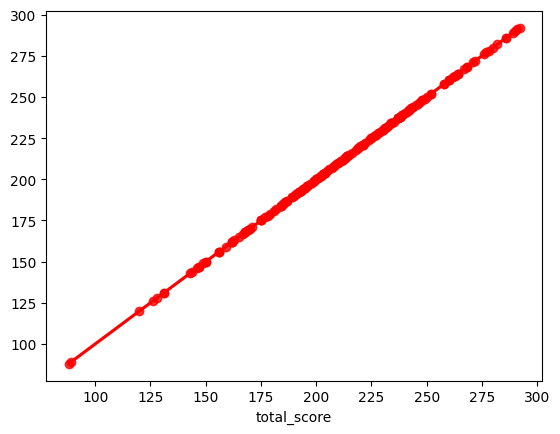

In [153]:
sns.regplot(x=Y_test,y=lin_y_pred,ci=None,color ='red');

In [154]:
pred_df=pd.DataFrame({'Actual Value':Y_test,'Predicted Value':lin_y_pred,'Difference':Y_test-lin_y_pred})
pred_df

,Actual Value,Predicted Value,Difference
521,208,208.0,2.842171e-14
737,234,234.0,0.000000e+00
740,149,149.0,5.684342e-14
660,206,206.0,2.842171e-14
411,248,248.0,0.000000e+00
...,...,...,...
408,271,271.0,0.000000e+00
332,192,192.0,2.842171e-14
208,190,190.0,2.842171e-14
613,203,203.0,5.684342e-14


Random Forest

In [155]:
rf_model = RandomForestRegressor(random_state=42)  # You can customize the hyperparameters if needed

rf_model.fit(X_train, Y_train)

# Step 2: Make predictions on both training and testing data
y_test_pred_rf = rf_model.predict(X_test)
score=r2_score(Y_test,y_test_pred_rf)
print(" Accuracy of the model is %.2f" %score)

 Accuracy of the model is 1.00


Text(0, 0.5, 'Predicted')

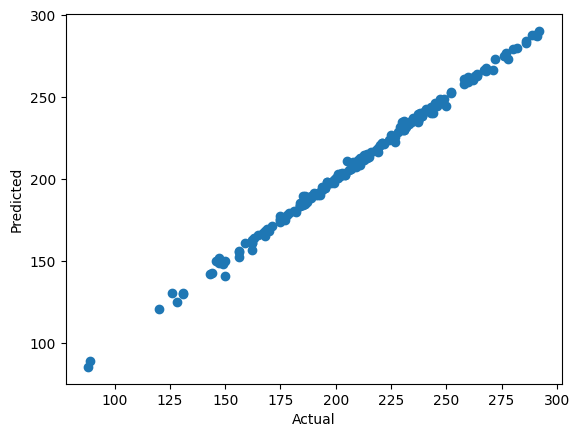

In [156]:
plt.scatter(Y_test,y_test_pred_rf)
plt.xlabel('Actual')
plt.ylabel('Predicted')

<Axes: xlabel='total_score'>

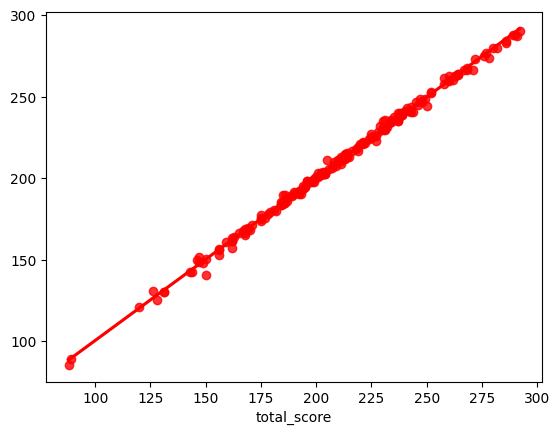

In [157]:
sns.regplot(x=Y_test,y=y_test_pred_rf,ci=None,color ='red')

In [158]:
pred=pd.DataFrame({'Actual Value':Y_test,'Predicted Value':y_test_pred_rf,'Difference':Y_test-y_test_pred_rf})
pred

,Actual Value,Predicted Value,Difference
521,208,210.17,-2.17
737,234,234.70,-0.70
740,149,148.28,0.72
660,206,205.67,0.33
411,248,247.14,0.86
...,...,...,...
408,271,266.39,4.61
332,192,191.88,0.12
208,190,191.64,-1.64
613,203,202.35,0.65
